creiamo uno script che apra un modello json fully connected e aggiunga delle skip connection dove vogliamo partendo dai modelli densi semplici
saranno quindi le stesse architetture ma con l'aggiunta delle ResNet

In [1]:
import tensorflow as tf
import os
import json
from keras.models import model_from_json
from keras.layers import Add, ReLU, Concatenate, Dense, Input
from keras.models import Model
from keras.utils import plot_model

import numpy as np

2025-01-17 13:29:26.018923: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
### funzione che apra i modelli
def open_json (path):
    with open(path,'r') as f:
        json_model = f.read()
    model = model_from_json(json_model)
    return model

In [7]:
### definiamo una funzione personalizzata che ci mostri anche il tipo di funzione di attivazione per ogni layer nel summary
### model sarà il modello e filename sarà il nome del file in cui salviamo il summary
def summary_with_activation(model, filename):
    with open(filename, 'w') as f:
        for layer in model.layers:
            config = layer.get_config()
            activation = config.get('activation', 'N/A')
            f.write(f"Layer: {layer.name}, Activation: {activation}\n")
        model.summary(print_fn=lambda x: f.write(x + '\n'))

In [5]:
#### una funzione che aggiunga le skip connections ad un modello esistente
#### model è il modello di partenza
#### positions:: array[int] sono i punti da cui partono le skip connections
#### layers_to_skip:: int sono i layer che vengono "saltati" dalla skip connection (i ResNet block avranno sempre la stessa dimensione)
def add_skip_connections (model, positions, layers_to_skip):
    ### ci salviamo tutti i layers
    layers = model.layers
    ### ci salviamo tutte le dimensioni dei layer
    units = [layer.output.shape[1] for layer in layers]
    ### in delta_skip_shapes salveremo le variazioni di dimensione tra i layer da cui partono e i layer in cui si ricongiungono le skip connections
    delta_skip_shapes = []
    for pos in positions:
        delta_skip_shapes.append(int(units[pos+layers_to_skip]-units[pos]))
    print(units)
    print(f"le skip connection sono nelle posizioni {positions}")
    print(f"le skip connection devo variare le dimensioni di {delta_skip_shapes}")
    junction_index = -1
    ### la variabile skip_count ci indica se dobbiamo saltare le interazioni del ciclo, la utilizziamo in corrispondenza dei ResNet block
    ### che vengono inseriti tutti insieme per non ri-aggiungere due volte i medesimi layer
    skip_count = 0
    for i in range (len(layers)-1):
        ### se siamo al primo layer definiamo un layer di Input
        if i == 0:
            x = Input(shape=(units[i],))
            input_layer = x
        ### se siamo in una delle posizioni subito dopo il punto in cui parte una skip connection ci salviamo l'output del layer precedente i addends_1
        ### e lo proiettiamo in nella dimensione che dovrà avere, SENZA attivazione (deve essere una semplice proiezione lineare)
        if i in positions+1:
            ### in connection_index identifichiamo quale skip connection stiamo trattando
            connection_index = np.where(positions+1 == i)[0][0]
            ### se delta_skip[connection_index] non è nullo si deve proittare l'output del layer precedente nella dimensione che dovrà avere al momento del layer Add()
            if delta_skip_shapes[connection_index] != 0:
                print(f'cambio dimensione da {x.shape[1]} a {x.shape[1]+delta_skip_shapes[connection_index]}')
                addend_1 = Dense(x.shape[1]+delta_skip_shapes[connection_index], activation = 'linear')(x)
            ### se delta_skip[connection_index] è nullo possiamo semplicemente prendere l'output del layer precedente
            else:
                addend_1 = x
            ### aggiungiamo tutto il ResNet block
            for j in range(i,i+layers_to_skip):
                print(f'aggiungiamo il layer {j}')
                x = Dense(units[j], activation = 'relu')(x)
                ### la variabile skip_count ci serve per saltare i prossimi layers_to_skip iterazioni del ciclo for principale, quindi per non riaggiungere il 
                ### ResNet block
                skip_count = skip_count+1
            print(f'la dimensione di addend_1 è {addend_1.shape[1]}')
            print(f'la dimensione di x è {x.shape[1]}')
            x = ReLU()(Add()([addend_1,x]))
            print(f'ripartiamo dal layer {j}')
        if i != 0: 
            ## se la variabile skip_count è diversa da 0 saltiamo questa iterazione
            if skip_count > 0:
                print(f'stiamo skippando il layer {i}')
                skip_count = skip_count -1
                continue
            print(f'aggiungiamo il layer {i}')
            x = Dense(units[i], activation = 'relu')(x)
    ### aggiungiamo il layer di output con attivazione sigmoid
    x = Dense(units[-1], activation = 'sigmoid')(x)
    new_model = Model(inputs = input_layer , outputs = x)
    new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return new_model

apriamo tutti i modelli fcNN che abbiamo creato e aggiungiamo le skip_connections 
pricipi generali :
 - non tocchiamo né l'input né l'output, quindi i ResNet block partiranno da dopo il secondo layer e finiranno prima del penultimo
 - i ResNet blocks avranno sempre la stessa dimensione (la dimensione di 2 l'abbiamo dall'articolo "Deep Residual Learning for Image Recognition" He et al.)
 - per i modelli con un numero dispari di layer ci fermiamo prima del terzultimo layer con l'aggiunta dei blocchi

In [ ]:
#### apriamo tutti i modelli fcNN constant
### path delle cartelle dei modelli
directory_constant_models = '/home/private/Hepd/Dataset_4/fcNN/normalized/constant'
### model_names: [string] lista con tutti i nomi dei modelli
constant_model_names = os.listdir(directory_constant_models)
### constant_models_path: [string] lista con i percorsi ai modelli fcNN pre-trainati
constant_model_paths = []
for name in constant_model_names:
    constant_model_paths.append(directory_constant_models+'/'+name+'/'+name+'.json')
### apriamo ogni modello contenuto nel path
for model_path in constant_model_paths:
    model = open_json(model_path)
    ### una volta aperto il modello definiamo le posizioni delle skip_connections in base al numero di layer (pari o dispari)
    ### es. posizione 1 significa che la skip connection partirà da immediatamente dopo il layer 1 e arriverà immediatamente dopo il layer 3
    ### questo perché i ResNet block avranno semopre la dimensione di 2
    ### per i modelli di profondità pari arriviamo al penultimo layer con l'ultima skip connection
    ### per i modelli con profondità dispari arriviamo al terzultimo
    depth = len(model.layers)
    ### per i modelli con profondità 4 o 5 non è possibile aggiungere le skip connections, non ci saranno questi modelli ResNet
    if depth == 5 or depth == 4:
        continue
    if depth % 2 == 0:
        ### il numero di skip connection è pari a (depth - 4)/2 
        ### (depth - 4) perché partono da dopo il secondo e arrivano prima del penultimo layer
        ### /2 perché contengono 2 layer
        num_ResNet_blocks = int((depth-4)/2)
        ### positions: array[int] un array che conterrà le posizioni di partenza delle skip connection del modello
        positions = np.zeros(num_ResNet_blocks, dtype = int)
        ## skip_positions: int inidica la posizione di partenza delle skip connection, viene incrementata di 2 ogni volta che una posizione è aggiunta a positions
        ## la prima skip position è sempre in 1
        skip_position = 1
        for i in range (len(positions)):
            positions[i] = skip_position
            skip_position += 2
    if depth %2 != 0:
        ### il numero di skip connection è pari a (depth - 5)/2 
        ### (depth - 5) perché partono da dopo il secondo e arrivano prima del terzultimo layer
        ### /2 perché contengono 2 layer
        num_ResNet_blocks = int((depth-5)/2)
        ### positions: array[int] un array che conterrà le posizioni di partenza delle skip connection del modello
        positions = np.zeros(num_ResNet_blocks, dtype = int)
        ## skip_positions: int inidica la posizione di partenza delle skip connection, viene incrementata di 2 ogni volta che una posizione è aggiunta a positions
        ## la prima skip position è sempre in 1
        skip_position = 1
        for i in range (len(positions)):
            positions[i] = int(skip_position)
            skip_position += 2
   
    #### creiamo il nuovo modello con le skip_connection
    ResNet_model = add_skip_connections(model, positions, layers_to_skip = 2)
    #### creiamo il formato .json del modello ResNet
    ResNet_model_json = ResNet_model.to_json()
    
    ### salviamo il modello in formato .json in un nuovo indirizzo
    ### otteniamo il nome del modello di partenza che è contenuto tra il penultimo e l'ultimo / del path
    ### last_slash_index : indice dell'ultimo / in model_path
    last_slash_index = model_path.rfind('/')
    ### nexttolast_slash_index : indice del penultimo / in model_path
    nexttolast_slash_index = model_path.rfind('/', 0, last_slash_index)
    model_name = model_path[nexttolast_slash_index+1:last_slash_index]
    ### ci salviamo l'architettura che è contenuta tra l'inizio di model_name e il primo _
    first_underscore_index = model_name.find('_')
    architecture = model_name [:first_underscore_index]
    ### ci salviamo le specifiche (profondità e larghezza del layer caratteristico che sono contuenute dopo il primo _
    specifics = model_name [first_underscore_index+1:]
    ### ora possiamo deifinire il nuovo perorso in cui salvare il modello ResNet
    final_path = '/home/private/Hepd/Dataset_4/fcNN_ResNet/normalized_ResNet/'+architecture+'_ResNet/'+architecture+'_ResNet_'+specifics
    ### se la cartella nel destination path non esiste creiamola
    if not os.path.exists(final_path):
        os.makedirs(final_path)
    ### salviamoci il modello ResNet in formato .json
    with open(final_path+'/'+architecture+'_ResNet_'+specifics+'.json', 'w') as f:
        f.write(ResNet_model_json)    
    ### salviamoci il summary del modello ResNet
    summary_with_activation(model,final_path+'/'+architecture+'_ResNet_'+specifics+'_summary.txt')
    ### salviamoci il plot del ResNet_model
    plot_model(ResNet_model, to_file=final_path+'/'+architecture+'_ResNet_'+specifics+'_plot.png',show_shapes=True, show_layer_names=True)

In [ ]:
#### apriamo tutti i modelli fcNN bottle
### path delle cartelle dei modelli
directory_bottle_models = '/home/private/Hepd/Dataset_4/fcNN/normalized/bottle'
### model_names: [string] lista con tutti i nomi dei modelli
bottle_model_names = os.listdir(directory_bottle_models)
### bottle_models_path: [string] lista con i percorsi ai modelli fcNN pre-trainati
bottle_model_paths = []
for name in bottle_model_names:
    bottle_model_paths.append(directory_bottle_models+'/'+name+'/'+name+'.json')
### apriamo ogni modello contenuto nel path
for model_path in bottle_model_paths:
    model = open_json(model_path)
    ### una volta aperto il modello definiamo le posizioni delle skip_connections in base al numero di layer (pari o dispari)
    ### es. posizione 1 significa che la skip connection partirà da immediatamente dopo il layer 1 e arriverà immediatamente dopo il layer 3
    ### questo perché i ResNet block avranno semopre la dimensione di 2
    ### per i modelli di profondità pari arriviamo al penultimo layer con l'ultima skip connection
    ### per i modelli con profondità dispari arriviamo al terzultimo
    depth = len(model.layers)
    ### per i modelli con profondità 4 o 5 non è possibile aggiungere le skip connections, non ci saranno questi modelli ResNet
    if depth == 5 or depth == 4:
        continue
    if depth % 2 == 0:
        ### il numero di skip connection è pari a (depth - 4)/2 
        ### (depth - 4) perché partono da dopo il secondo e arrivano prima del penultimo layer
        ### /2 perché contengono 2 layer
        num_ResNet_blocks = int((depth-4)/2)
        ### positions: array[int] un array che conterrà le posizioni di partenza delle skip connection del modello
        positions = np.zeros(num_ResNet_blocks, dtype = int)
        ## skip_positions: int inidica la posizione di partenza delle skip connection, viene incrementata di 2 ogni volta che una posizione è aggiunta a positions
        ## la prima skip position è sempre in 1
        skip_position = 1
        for i in range (len(positions)):
            positions[i] = skip_position
            skip_position += 2
    if depth %2 != 0:
        ### il numero di skip connection è pari a (depth - 5)/2 
        ### (depth - 5) perché partono da dopo il secondo e arrivano prima del terzultimo layer
        ### /2 perché contengono 2 layer
        num_ResNet_blocks = int((depth-5)/2)
        ### positions: array[int] un array che conterrà le posizioni di partenza delle skip connection del modello
        positions = np.zeros(num_ResNet_blocks, dtype = int)
        ## skip_positions: int inidica la posizione di partenza delle skip connection, viene incrementata di 2 ogni volta che una posizione è aggiunta a positions
        ## la prima skip position è sempre in 1
        skip_position = 1
        for i in range (len(positions)):
            positions[i] = int(skip_position)
            skip_position += 2
   
    #### creiamo il nuovo modello con le skip_connection
    ResNet_model = add_skip_connections(model, positions, layers_to_skip = 2)
    #### creiamo il formato .json del modello ResNet
    ResNet_model_json = ResNet_model.to_json()
    
    ### salviamo il modello in formato .json in un nuovo indirizzo
    ### otteniamo il nome del modello di partenza che è contenuto tra il penultimo e l'ultimo / del path
    ### last_slash_index : indice dell'ultimo / in model_path
    last_slash_index = model_path.rfind('/')
    ### nexttolast_slash_index : indice del penultimo / in model_path
    nexttolast_slash_index = model_path.rfind('/', 0, last_slash_index)
    model_name = model_path[nexttolast_slash_index+1:last_slash_index]
    ### ci salviamo l'architettura che è contenuta tra l'inizio di model_name e il primo _
    first_underscore_index = model_name.find('_')
    architecture = model_name [:first_underscore_index]
    ### ci salviamo le specifiche (profondità e larghezza del layer caratteristico che sono contuenute dopo il primo _
    specifics = model_name [first_underscore_index+1:]
    ### ora possiamo deifinire il nuovo perorso in cui salvare il modello ResNet
    final_path = '/home/private/Hepd/Dataset_4/fcNN_ResNet/normalized_ResNet/'+architecture+'_ResNet/'+architecture+'_ResNet_'+specifics
    ### se la cartella nel destination path non esiste creiamola
    if not os.path.exists(final_path):
        os.makedirs(final_path)
    ### salviamoci il modello ResNet in formato .json
    with open(final_path+'/'+architecture+'_ResNet_'+specifics+'.json', 'w') as f:
        f.write(ResNet_model_json)
    ### salviamoci il summary del modello ResNet
    summary_with_activation(model,final_path+'/'+architecture+'_ResNet_'+specifics+'_summary.txt')
    ### salviamoci il plot del ResNet_model
    plot_model(ResNet_model, to_file=final_path+'/'+architecture+'_ResNet_'+specifics+'_plot.png',show_shapes=True, show_layer_names=True)

In [10]:
#### apriamo tutti i modelli fcNN funnel
### path delle cartelle dei modelli
directory_funnel_models = '/home/private/Hepd/Dataset_4/fcNN/normalized/funnel'
### model_names: [string] lista con tutti i nomi dei modelli
funnel_model_names = os.listdir(directory_funnel_models)
### funnel_models_path: [string] lista con i percorsi ai modelli fcNN pre-trainati
funnel_model_paths = []
for name in funnel_model_names:
    funnel_model_paths.append(directory_funnel_models+'/'+name+'/'+name+'.json')
### apriamo ogni modello contenuto nel path
for model_path in funnel_model_paths:
    model = open_json(model_path)
    ### una volta aperto il modello definiamo le posizioni delle skip_connections in base al numero di layer (pari o dispari)
    ### es. posizione 1 significa che la skip connection partirà da immediatamente dopo il layer 1 e arriverà immediatamente dopo il layer 3
    ### questo perché i ResNet block avranno semopre la dimensione di 2
    ### per i modelli di profondità pari arriviamo al penultimo layer con l'ultima skip connection
    ### per i modelli con profondità dispari arriviamo al terzultimo
    depth = len(model.layers)
    ### per i modelli con profondità 4 o 5 non è possibile aggiungere le skip connections, non ci saranno questi modelli ResNet
    if depth == 5 or depth == 4:
        continue
    if depth % 2 == 0:
        ### il numero di skip connection è pari a (depth - 4)/2 
        ### (depth - 4) perché partono da dopo il secondo e arrivano prima del penultimo layer
        ### /2 perché contengono 2 layer
        num_ResNet_blocks = int((depth-4)/2)
        ### positions: array[int] un array che conterrà le posizioni di partenza delle skip connection del modello
        positions = np.zeros(num_ResNet_blocks, dtype = int)
        ## skip_positions: int inidica la posizione di partenza delle skip connection, viene incrementata di 2 ogni volta che una posizione è aggiunta a positions
        ## la prima skip position è sempre in 1
        skip_position = 1
        for i in range (len(positions)):
            positions[i] = skip_position
            skip_position += 2
    if depth %2 != 0:
        ### il numero di skip connection è pari a (depth - 5)/2 
        ### (depth - 5) perché partono da dopo il secondo e arrivano prima del terzultimo layer
        ### /2 perché contengono 2 layer
        num_ResNet_blocks = int((depth-5)/2)
        ### positions: array[int] un array che conterrà le posizioni di partenza delle skip connection del modello
        positions = np.zeros(num_ResNet_blocks, dtype = int)
        ## skip_positions: int inidica la posizione di partenza delle skip connection, viene incrementata di 2 ogni volta che una posizione è aggiunta a positions
        ## la prima skip position è sempre in 1
        skip_position = 1
        for i in range (len(positions)):
            positions[i] = int(skip_position)
            skip_position += 2
   
    #### creiamo il nuovo modello con le skip_connection
    ResNet_model = add_skip_connections(model, positions, layers_to_skip = 2)
    #### creiamo il formato .json del modello ResNet
    ResNet_model_json = ResNet_model.to_json()
    
    ### salviamo il modello in formato .json in un nuovo indirizzo
    ### otteniamo il nome del modello di partenza che è contenuto tra il penultimo e l'ultimo / del path
    ### last_slash_index : indice dell'ultimo / in model_path
    last_slash_index = model_path.rfind('/')
    ### nexttolast_slash_index : indice del penultimo / in model_path
    nexttolast_slash_index = model_path.rfind('/', 0, last_slash_index)
    model_name = model_path[nexttolast_slash_index+1:last_slash_index]
    ### ci salviamo l'architettura che è contenuta tra l'inizio di model_name e il primo _
    first_underscore_index = model_name.find('_')
    architecture = model_name [:first_underscore_index]
    ### ci salviamo le specifiche (profondità e larghezza del layer caratteristico che sono contuenute dopo il primo _
    specifics = model_name [first_underscore_index+1:]
    ### ora possiamo deifinire il nuovo perorso in cui salvare il modello ResNet
    final_path = '/home/private/Hepd/Dataset_4/fcNN_ResNet/normalized_ResNet/'+architecture+'_ResNet/'+architecture+'_ResNet_'+specifics
    ### se la cartella nel destination path non esiste creiamola
    if not os.path.exists(final_path):
        os.makedirs(final_path)
    ### salviamoci il modello ResNet in formato .json
    with open(final_path+'/'+architecture+'_ResNet_'+specifics+'.json', 'w') as f:
        f.write(ResNet_model_json)
    ### salviamoci il summary del modello ResNet
    summary_with_activation(model,final_path+'/'+architecture+'_ResNet_'+specifics+'_summary.txt')
    ### salviamoci il plot del ResNet_model
    plot_model(ResNet_model, to_file=final_path+'/'+architecture+'_ResNet_'+specifics+'_plot.png',show_shapes=True, show_layer_names=True)

[40, 170, 151, 132, 113, 94, 75, 56, 37, 16, 1]
le skip connection sono nelle posizioni [1 3 5]
le skip connection devo variare le dimensioni di [-38, -38, -38]
aggiungiamo il layer 1
cambio dimensione da 170 a 132
aggiungiamo il layer 2
aggiungiamo il layer 3
la dimensione di addend_1 è 132
la dimensione di x è 132
ripartiamo dal layer 3
stiamo skippando il layer 2
stiamo skippando il layer 3
cambio dimensione da 132 a 94
aggiungiamo il layer 4
aggiungiamo il layer 5
la dimensione di addend_1 è 94
la dimensione di x è 94
ripartiamo dal layer 5
stiamo skippando il layer 4
stiamo skippando il layer 5
cambio dimensione da 94 a 56
aggiungiamo il layer 6
aggiungiamo il layer 7
la dimensione di addend_1 è 56
la dimensione di x è 56
ripartiamo dal layer 7
stiamo skippando il layer 6
stiamo skippando il layer 7
aggiungiamo il layer 8
aggiungiamo il layer 9
[40, 512, 430, 348, 266, 184, 102, 16, 1]
le skip connection sono nelle posizioni [1 3]
le skip connection devo variare le dimensioni di [

In [989]:
positions = np.array([1, 3, 5])
layers_to_skip = 2
extra_layer_model = add_skip_connections(model,positions,layers_to_skip)

[40, 54, 54, 54, 54, 54, 54, 54, 54, 1]
le skip connection sono nelle posizioni [1 3 5]
le skip connection devo variare le dimensioni di [0, 0, 0]
aggiungiamo il layer 1
aggiungiamo il layer 2
aggiungiamo il layer 3
la dimensione di addend_1 è 54
la dimensione di x è 54
ripartiamo dal layer 3
stiamo skippando il layer 2
stiamo skippando il layer 3
aggiungiamo il layer 4
aggiungiamo il layer 5
la dimensione di addend_1 è 54
la dimensione di x è 54
ripartiamo dal layer 5
stiamo skippando il layer 4
stiamo skippando il layer 5
aggiungiamo il layer 6
aggiungiamo il layer 7
la dimensione di addend_1 è 54
la dimensione di x è 54
ripartiamo dal layer 7
stiamo skippando il layer 6
stiamo skippando il layer 7
aggiungiamo il layer 8
aggiungiamo il layer 9


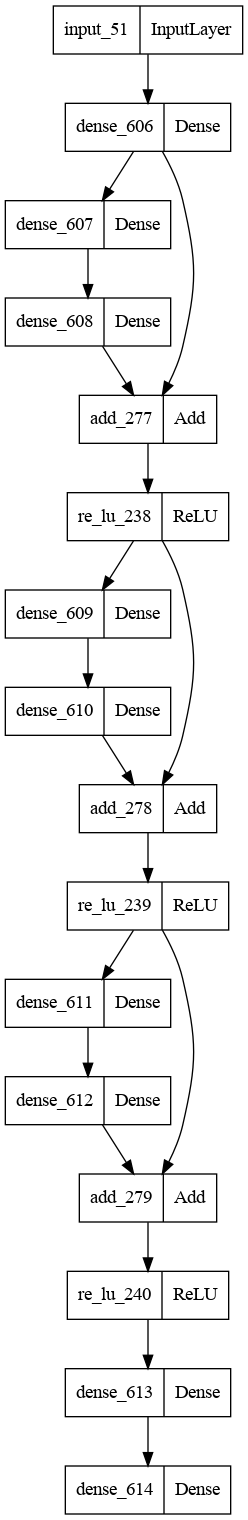

In [990]:
plot_model(extra_layer_model)

In [822]:
for layer in extra_layer_model.layers:
    print(layer.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name='input_2329'), name='input_2329', description="created by layer 'input_2329'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='dense_223/Relu:0', description="created by layer 'dense_223'")
KerasTensor(type_spec=TensorSpec(shape=(None, 21), dtype=tf.float32, name=None), name='dense_224/Relu:0', description="created by layer 'dense_224'")
KerasTensor(type_spec=TensorSpec(shape=(None, 26), dtype=tf.float32, name=None), name='dense_225/Relu:0', description="created by layer 'dense_225'")
KerasTensor(type_spec=TensorSpec(shape=(None, 31), dtype=tf.float32, name=None), name='dense_226/Relu:0', description="created by layer 'dense_226'")
KerasTensor(type_spec=TensorSpec(shape=(None, 36), dtype=tf.float32, name=None), name='dense_227/Relu:0', description="created by layer 'dense_227'")
KerasTensor(type_spec=TensorSpec(shape=(None, 30), dtype=tf.float32, name=None), name='dense_228/